In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Setup codes

In [7]:
import numpy as np
import pandas as pd
import os
import nltk
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from collections import OrderedDict
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import TensorDataset

In [8]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import numpy as np
import os
import time

In [9]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')
  
device = torch.device('cuda:0')

Good to go!


In [10]:
np.set_printoptions(linewidth=np.inf)

pcp = ['A(bass)', 'Bb(bass)', 'B(bass)', 'C(bass)', 'C#(bass)', 'D(bass)', 'Eb(bass)', 'E(bass)', 'F(bass)', 'F#(bass)', 'G(bass)', 'Ab(bass)', 'A', 'Bb', 'B', 'C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab']

chord2index = {'N': 0, 'B#:maj': 1, 'C:maj': 1, 'C#:maj': 2, 'Db:maj': 2, 'D:maj': 3, 'D#:maj': 4, 'Eb:maj': 4, 'E:maj': 5, 'Fb:maj': 5, 'E#:maj': 6, 'F:maj': 6, 'F#:maj': 7, 'Gb:maj': 7, 'G:maj': 8, 'G#:maj': 9, 'Ab:maj': 9, 'A:maj': 10, 'A#:maj': 11, 'Bb:maj': 11, 'B:maj': 12, 'Cb:maj': 12, 'B#:min': 13, 'C:min': 13, 'C#:min': 14, 'Db:min': 14, 'D:min': 15, 'D#:min': 16, 'Eb:min': 16, 'E:min': 17, 'Fb:min': 17, 'E#:min': 18, 'F:min': 18, 'F#:min': 19, 'Gb:min': 19, 'G:min': 20, 'G#:min': 21, 'Ab:min': 21, 'A:min': 22, 'A#:min': 23, 'Bb:min': 23, 'B:min': 24, 'Cb:min': 24, 'X': 25}
index2chord = {0: 'N', 1: 'C:maj', 2: 'C#:maj', 3: 'D:maj', 4: 'Eb:maj', 5: 'E:maj', 6: 'F:maj', 7: 'F#:maj', 8: 'G:maj', 9: 'Ab:maj', 10: 'A:maj', 11: 'Bb:maj', 12: 'B:maj', 13: 'C:min', 14: 'C#:min', 15: 'D:min', 16: 'Eb:min', 17: 'E:min', 18: 'F:min', 19: 'F#:min', 20: 'G:min', 21: 'Ab:min', 22: 'A:min', 23: 'Bb:min', 24: 'B:min', 25: 'X'}

num_chords = len(index2chord)

chroma_path = '/content/drive/MyDrive/ML Project/McGill-Billboard-2.0-chordino/'
chord_path = '/content/drive/MyDrive/ML Project/McGill-Billboard-2.0-mirex/'

files = os.listdir(chroma_path)

batch_size = 64
print_every = 500
num_pcp = len(pcp)
smax = 90000

random.seed(1)

In [12]:
checkpoint_general = torch.load('/content/drive/MyDrive/ML Project/data/General_data.tar')

# General data
file_infos = checkpoint_general['file_infos']
train_files = checkpoint_general['train_files']
validation_files = checkpoint_general['validation_files']
test_files = checkpoint_general['test_files']


checkpoint_LSTM = torch.load('/content/drive/MyDrive/ML Project/data/LSTM_data.tar')

# Task 2: LSTM data
train_chord_sequences = checkpoint_LSTM['train_chord_sequences'] 
validation_chord_sequences = checkpoint_LSTM['validation_chord_sequences']
test_chord_sequences = checkpoint_LSTM['test_chord_sequences']

# Tensorflow

In [13]:
seq_length = 200

In [14]:
flat_train = []
for song in train_chord_sequences:
  cut_length = len(song) % (seq_length + 1)
  flat_train += song[:-cut_length]

In [15]:
chord_dataset = tf.data.Dataset.from_tensor_slices(np.array(flat_train))

In [16]:
sequences = chord_dataset.batch(seq_length+1, drop_remainder=True)

In [17]:
def construct_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(construct_input_target)

In [18]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [19]:
embedding_dim = 100
rnn_units = 1024

In [20]:
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Embedding, GRU, Dense 

def build_model(embedding_dim, rnn_units, batch_size):
    model = Sequential([
        Embedding(num_chords, embedding_dim,
                  batch_input_shape=[batch_size, None]
        ),
        
        GRU(rnn_units, # Positive integer, dimensionality of the output space.
            return_sequences=True, # Whether to return just last output only or the full sequence.
            stateful=True,  #If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
            recurrent_initializer='glorot_uniform'
        ),
        
        Dense(num_chords)
    ])
    return model

In [21]:
model = build_model(
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 100)           2600      
                                                                 
 gru (GRU)                   (64, None, 1024)          3459072   
                                                                 
 dense (Dense)               (64, None, 26)            26650     
                                                                 
Total params: 3,488,322
Trainable params: 3,488,322
Non-trainable params: 0
_________________________________________________________________


In [22]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', 
              loss=loss)

In [23]:
# Directory where the checkpoints will be saved
checkpoint_dir = '/content/drive/MyDrive/ML Project/data/training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
history = model.fit(dataset, 
                    epochs=30, 
                    callbacks=[checkpoint_callback])

Epoch 1/30
151/151 [==============================] - 21s 85ms/step - loss: 0.7572
Epoch 2/30
151/151 [==============================] - 15s 86ms/step - loss: 0.1549
Epoch 3/30
151/151 [==============================] - 15s 87ms/step - loss: 0.1401
Epoch 4/30
151/151 [==============================] - 16s 87ms/step - loss: 0.1361
Epoch 5/30
151/151 [==============================] - 15s 88ms/step - loss: 0.1345
Epoch 6/30
151/151 [==============================] - 17s 90ms/step - loss: 0.1336
Epoch 7/30
151/151 [==============================] - 16s 89ms/step - loss: 0.1329
Epoch 8/30
151/151 [==============================] - 16s 90ms/step - loss: 0.1323
Epoch 9/30
151/151 [==============================] - 16s 90ms/step - loss: 0.1321
Epoch 10/30
151/151 [==============================] - 16s 90ms/step - loss: 0.1316
Epoch 11/30
151/151 [==============================] - 16s 90ms/step - loss: 0.1315
Epoch 12/30
151/151 [==============================] - 16s 90ms/step - loss: 0.1312
E

In [24]:
# Rebuild the model by changing batch size (=1) to predict new text
model = build_model(embedding_dim, rnn_units, batch_size=1)

# Load the weight of the model we trained 
# model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.load_weights('/content/drive/MyDrive/ML Project/data/training_checkpoints/ckpt_30')

# Change the batch size from 64 to 1
model.build(tf.TensorShape([1, None]))

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 100)            2600      
                                                                 
 gru_1 (GRU)                 (1, None, 1024)           3459072   
                                                                 
 dense_1 (Dense)             (1, None, 26)             26650     
                                                                 
Total params: 3,488,322
Trainable params: 3,488,322
Non-trainable params: 0
_________________________________________________________________


In [26]:
def generate_chords(model, start_chords, num_generate,temperature):
    # Evaluation step (generating text using the learned model)

    input_eval = tf.expand_dims(start_chords, 0)

    # Empty list to store our results
    chords_generated = []

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        #predicted_id = tf.argmax(predictions[-1, :])

        # We pass the predicted chord as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        chords_generated.append(predicted_id)

    return chords_generated

In [27]:
file_index = 0
validation_file = validation_files[file_index]
validation_chord_sequence = validation_chord_sequences[file_index]
file_length = len(validation_chord_sequence)

In [28]:
print(validation_file)

0787


In [29]:
print(file_length)

2944


In [30]:
chords_generated = generate_chords(model, start_chords=validation_chord_sequence[:file_length//2], num_generate = file_length//2, temperature=0.8)

# Plot

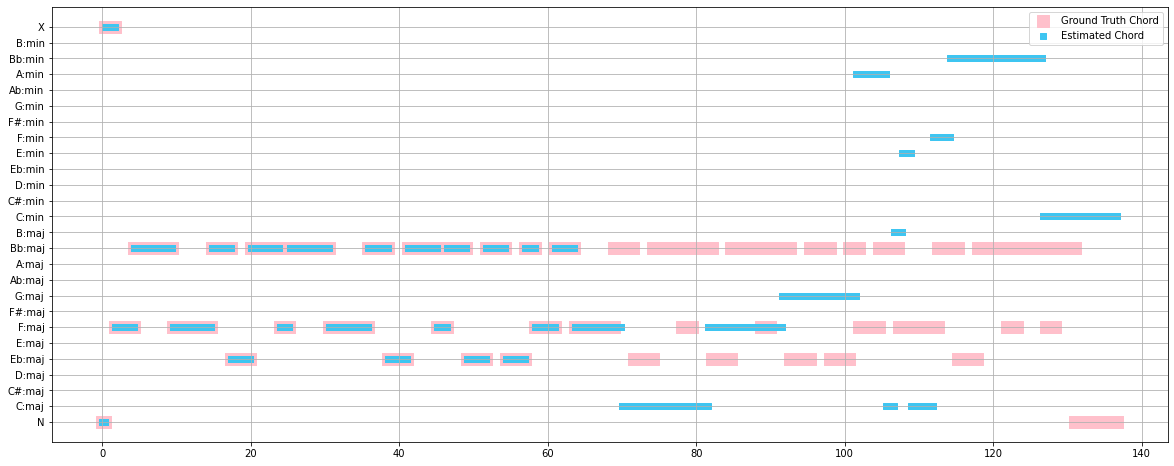

In [31]:
import matplotlib.pyplot as plt

delta_t = 2048/44100
length = len(validation_chord_sequence)
X = np.arange(length) * delta_t
preds = validation_chord_sequence[:file_length//2] + chords_generated
targets = validation_chord_sequence

fig = plt.figure(figsize=(20, 8))
plt.scatter(X, targets, c='#ffc0cb', s=130, marker = 's', edgecolor=None, label = 'Ground Truth Chord')
plt.scatter(X, preds, c='#3ec5f1', marker = 's', edgecolor=None, label = 'Estimated Chord')
plt.yticks(np.arange(num_chords), labels=index2chord.values())
plt.grid(True, axis='both')
plt.legend()
plt.show()

# Chord Player

In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
def get_chords_time(chord_sequence, bar_time):

  # Count the chords
  chords_count = []
  last = [-1, 0]
  for chord in chord_sequence:
    if chord == last[0]:
      last[1] += 1
    else:
      chords_count.append(last)
      last = [chord, 1]
  chords_count.append(last)
  chords_count = chords_count[1:]

  # Change the count into time (ms)
  for i in range(len(chords_count)):
    chords_count[i][1] = int(chords_count[i][1] * 20480 / 441) // bar_time * bar_time
  
  while chords_count:
    while chords_count[0][1]:
      yield(chords_count[0][0], 500)
      chords_count[0][1] -= 500
    chords_count = chords_count[1:]

In [70]:
from pydub import AudioSegment

chord_files_path = '/content/drive/MyDrive/ML Project/chord_files/'
audio_files = [None]
for i in range(1, 25):
  audio_files.append(AudioSegment.from_file(chord_files_path + str(i) + '.wav', format="wav"))

In [83]:
output = AudioSegment.empty()

for chord, time in get_chords_time(chords_generated, 500):
  if chord in range(1, 25):
    output += audio_files[chord][:time]
  else:
    output += AudioSegment.silent(duration=time)

file_handle = output.export("/content/drive/MyDrive/ML Project/output.mp3", format="mp3")

TypeError: ignored

In [79]:
output